In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
'''
Итоговые задания для меня:
    + перенести весь необходимый для запуска семинара код dlnlputils (с учетом моих ранее проиизведенных модификаций)
    + проанализировать и понять код семинара (если нужно, добавить развернутые комментарии)
'''

'\nИтоговые задания для меня:\n    + перенести весь необходимый для запуска семинара код dlnlputils (с учетом моих ранее проиизведенных модификаций)\n    + проанализировать и понять код семинара (если нужно, добавить развернутые комментарии)\n'

In [3]:
# Для выполнения этого задания не забудьте установить:
!pip3 install spacy_udpipe
!pip3 install ipymarkup
!pip3 install livelossplot

     |████████████████████████████████| 304 kB 291 kB/s            
  Preparing metadata (setup.py) ... - \ done
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=9643993 sha256=31506ede3a2d1a60bb6b65901d4e5875562a422fa98bd6586b39503a0d20c417
  Stored in directory: /root/.cache/pip/wheels/b8/b5/8e/3da091629a21ce2d10bf90759d0cb034ba10a5cf7a01e83d64
Successfully built ufal.udpipe
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy

### Код из библиотеки dlnlputils репозитория https://github.com/Samsung-IT-Academy/stepik-dl-nlp

In [4]:
# stepik-dl-nlp/dlnlputils/data/base.py#########

import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

def character_tokenize(txt):
    return list(txt)

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

def tokenize_corpus_verbose(texts, tokenizer=tokenize_text_simple_regex, verbose_chunk=1000, **tokenizer_kwargs):
    tokenize_texts = []
    for i, text in enumerate(texts):
        tokenize_texts.append(tokenizer(text, **tokenizer_kwargs))
        if i % verbose_chunk == 0:
            print('Complete: {}/{}'.format(i,len(texts)))
    return tokenize_texts

def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None, start_end_tag = False):
    #modified add start/end tags of words
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])
    
    # добавим теги начала и конца слова, для задачи POS-tagging
    if start_end_tag and pad_word is not None:
        sorted_word_counts = [('<START>', 1)] + [('<END>', 2)] + sorted_word_counts
    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


#########stepik-dl-nlp/dlnlputils/data/bag_of_words.py#########

import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    #modified by me 
    #add 'lftidf', 'tflidf', 'ltflidf', 'ltf', 'lidf'
    
    assert mode in {'tfidf', 'idf', 'tf', 'bin', 'ltfidf', 'tflidf', 'tflidf_v2', 'ltf', 'tfpmi'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    elif mode == 'ltf': # lTF=ln⁡(TF+1)
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))
 
    elif mode == 'lidf': # lIDF=ln⁡(n/IDF+1)
        result = (result > 0).astype('float32').multiply(len(tokenized_texts) / word2freq)
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))

        
    elif mode == 'ltfidf': # lTFIDF=ln⁡(TF+1)⋅IDF
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))
        result = result.multiply(1 / word2freq) # разделить каждый столбец на вес слова
        

    elif mode == 'tflidf': # lTFIDF=TF⋅ln⁡(1/IDF+1)
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = result.multiply(np.log(1 / word2freq + 1)) # разделить каждый столбец на вес слова

    elif mode == 'tflidf_v2': # lTFIDF=TF⋅ln⁡(n/IDF+1)
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = result.multiply(np.log(len(tokenized_texts) / word2freq + 1)) # разделить каждый столбец на вес слова
        
    elif mode == 'tfpmi': # TFPMI=TF⋅PMI
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(word2freq)  # домножить каждую строку на word2freq (это массив PMI Scores)

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label
    
    
#########stepik-dl-nlp/dlnlputils/pipeline.py#########

import copy
import datetime
import random
import traceback

import numpy as np
import torch
from torch.utils.data import DataLoader


def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True


def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0,
                    best_acc_type = 'loss',
                    test_dataset = None,
                    experiment_name = 'NoName',
                    no_calculate_accuracy = False):
    """
    v2.3
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    
    '''
    modified by wisoffe
    best_acc_type: 'loss' or 'acc'
    experiment_name: 
    '''
    assert best_acc_type in {'loss', 'acc'}
    
    train_start_time = datetime.datetime.now()
    print("############## Start experiment with name: {} ##############".format(experiment_name))
    
    #statistics history
    history = {'acc': {'train': [0.0],
                       'val': [0.0]},
               'loss': {'train': [float('inf')],
                       'val': [float('inf')]}}
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)
    
    if best_acc_type == 'loss': #отбираем модель по минимальному loss
        best_val_metric = float('inf')
    elif best_acc_type == 'acc': #отбираем модель по максимальному accuracy
        best_val_metric = float('-inf')
        
    best_epoch_i = 0
    best_model = copy.deepcopy(model)
    
    
    for epoch_i in range(1, epoch_n + 1):
        try:
            #####train phase######
            epoch_start = datetime.datetime.now()
            train_accuracy_epoch = [] #for statistics
            train_loss_epoch = [] #for statistics
            
            model.train()
            
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    print('Threshold max_batches_per_epoch_train exceeded!')
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                train_loss_epoch.append(float(loss))
                
                if not no_calculate_accuracy:
                    train_accuracy_epoch.append(float((pred.argmax(dim=1) == batch_y.data).float().mean().data))
                    #train_accuracy_epoch.append(float((pred.detach().cpu().numpy().argmax(-1) == batch_y.detach().cpu().numpy()).mean()))
                else: train_accuracy_epoch.append(0.)
                    
            train_iters = batch_i
            #####validation phase######
            model.eval()

            val_accuracy_epoch = [] #for statistics
            val_loss_epoch = [] #for statistics

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        print('Threshold max_batches_per_epoch_val exceeded!')
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)
                    
                    if not no_calculate_accuracy:
                        val_accuracy_epoch.append(float((pred.argmax(dim=1) == batch_y.data).float().mean().data))
                        #val_accuracy_epoch.append(float((pred.detach().cpu().numpy().argmax(-1) == batch_y.detach().cpu().numpy()).mean()))
                    else:
                        val_accuracy_epoch.append(0.)
                    val_loss_epoch.append(float(loss))

            
            ########ending of epoch#########
            
            history['acc']['train'].append(sum(train_accuracy_epoch) / len(train_accuracy_epoch))
            history['loss']['train'].append(sum(train_loss_epoch) / len(train_loss_epoch))  

            history['acc']['val'].append(sum(val_accuracy_epoch) / len(val_accuracy_epoch))
            history['loss']['val'].append(sum(val_loss_epoch) / len(val_loss_epoch))
            
            
            #save best model
            best_model_saved = False
            if (best_acc_type == 'loss' and history['loss']['val'][-1] < best_val_metric) or \
                    (best_acc_type == 'acc' and history['acc']['val'][-1] > best_val_metric):
                #отбираем модель по минимальному loss или максимальному accuracy
                best_epoch_i = epoch_i
                best_val_metric = history[best_acc_type]['val'][-1]
                best_model = copy.deepcopy(model)
                best_model_saved = True
            #check for break training
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(history['loss']['val'][-1])
            
            #output statistics
            
            print('Epoch = {:>3},   ACC: val = {:.4f}, train = {:.4f}    LOSS: val = {:.4f}, train = {:.4f}   SAVE: {}, Iters: {}, Time: {:0.2f}s'\
                  .format(epoch_i,
                          history['acc']['val'][-1], 
                          history['acc']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          best_model_saved,
                          train_iters,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
            
    print(' ')
    print("BEST MODEL: ACC: val = {:.4f}, train = {:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, metric type = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          best_acc_type,
                          (datetime.datetime.now() - train_start_time).total_seconds()))
    print("************** End experiment with name: {} **************".format(experiment_name))
    print(' ')
    history['BEST'] = {}
    history['BEST']['epoch'] = best_epoch_i
    history['BEST']['dict_size'] = batch_x.shape[-1]
    
    
    #calculate and save final metrics best_model on train/val/test datasets
    if test_dataset is not None:
        history['BEST']['acc'] = {}
        history['BEST']['loss'] = {}
        
        #save validation metrics (no calculate again)
        history['BEST']['acc']['val'] = history['acc']['val'][best_epoch_i]
        history['BEST']['loss']['val'] = history['loss']['val'][best_epoch_i]
        
        #calculate and save train metrics
        train_pred = predict_with_model(best_model, train_dataset, return_labels=True)
        history['BEST']['loss']['train'] = float(F.cross_entropy(torch.from_numpy(train_pred[0]),
                             torch.from_numpy(train_pred[1]).long()))
        history['BEST']['acc']['train'] = accuracy_score(train_pred[1], train_pred[0].argmax(-1))
        
        #calculate and save test metrics
        test_pred = predict_with_model(best_model, test_dataset, return_labels=True)
        history['BEST']['loss']['test'] = float(F.cross_entropy(torch.from_numpy(test_pred[0]),
                             torch.from_numpy(test_pred[1]).long()))
        history['BEST']['acc']['test'] = accuracy_score(test_pred[1], test_pred[0].argmax(-1))    
    
    best_model.eval()
    
    return history, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)


#########stepik-dl-nlp/dlnlputils/nnets.py#########

from torch.utils.data import Dataset


def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target

    
def make_mask_from_lengths(lengths, max_length):
    result = torch.zeros(len(lengths), max_length, dtype=torch.bool)
    for sample_i, cur_len in enumerate(lengths):
        result[sample_i, :cur_len] = 1
    return result

#########stepik-dl-nlp/dlnlputils/embeddings.py#########

class Embeddings:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def most_similar(self, positive=None, negative=None, topk=10, with_mean = False):
        #modified by wis, converted to gensim syntax
        
        if positive is not None:
            if type(positive) != list:
                positive = [positive]
            pos_vec = [self.get_vector(word) for word in positive]
            pos_len = len(positive)
        else:
            pos_vec = 0
            pos_len = 1
            
        if negative is not None:
            if type(negative) != list:
                negative = [negative]
            neg_vec = [self.get_vector(word) for word in negative]
            neg_len = len(negative)
        else:
            neg_vec = 0
            neg_len = 1
        
        if with_mean:
            result_vec = np.array(pos_vec).sum(0) / pos_len - np.array(neg_vec).sum(0) / neg_len
        else:
            result_vec = np.array(pos_vec).sum(0) - np.array(neg_vec).sum(0)
        
        return self.most_similar_by_vector(result_vec, topk=topk)
    
    def most_similar_legacy(self, word, topk=10):
        return self.most_similar_by_vector(self.get_vector(word), topk=topk)

    def analogy(self, a1, b1, a2, topk=10):
        a1_v = self.get_vector(a1)
        b1_v = self.get_vector(b1)
        a2_v = self.get_vector(a2)
        query = b1_v - a1_v + a2_v
        return self.most_similar_by_vector(query, topk=topk)

    def most_similar_by_vector(self, query_vector, topk=10):
        similarities = (self.embeddings * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
        result = [(self.id2word[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors

#########stepik-dl-nlp/dlnlputils/visualization.py#########

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE


def plot_vectors(vectors, labels, how='tsne', ax=None, xy_lim=None):
    if how == 'tsne':
        projections = TSNE().fit_transform(vectors)
    elif how == 'svd':
        projections = TruncatedSVD().fit_transform(vectors)

    x = projections[:, 0]
    y = projections[:, 1]
    if xy_lim is not None:
        ax.set_xlim(xy_lim)
        ax.set_ylim(xy_lim)
    ax.scatter(x, y)
    for cur_x, cur_y, cur_label in zip(x, y, labels):
        ax.annotate(cur_label, (cur_x, cur_y))
        

#########stepik-dl-nlp/dlnlputils/data/pos.py#########
import torch
from torch.utils.data import TensorDataset

def pos_corpus_to_tensor(sentences, char2id, label2id, max_sent_len, max_token_len):
    #v1.2 add custom start/end tag functionaly
    inputs = torch.zeros((len(sentences), max_sent_len, max_token_len + 2), dtype=torch.long)
    inputs[:,:,0] = char2id.get('<START>', 0)
    targets = torch.zeros((len(sentences), max_sent_len), dtype=torch.long)

    for sent_i, sent in enumerate(sentences):
        for token_i, token in enumerate(sent):
            targets[sent_i, token_i] = label2id.get(token.upos, 0)
            if token.form is not None:
                for char_i, char in enumerate(token.form):
                    inputs[sent_i, token_i, char_i + 1] = char2id.get(char, 0)
            else:
                for char_i, char in enumerate('-'):
                    inputs[sent_i, token_i, char_i + 1] = char2id.get(char, 0)
            inputs[sent_i, token_i, char_i + 2] = char2id.get('<END>', 0)

    return inputs, targets


class POSTagger:
    def __init__(self, model, char2id, id2label, max_sent_len, max_token_len):
        self.model = model
        self.char2id = char2id
        self.id2label = id2label
        self.max_sent_len = max_sent_len
        self.max_token_len = max_token_len

    def __call__(self, sentences):
        tokenized_corpus = tokenize_corpus(sentences, min_token_size=1)

        inputs = torch.zeros((len(sentences), self.max_sent_len, self.max_token_len + 2), dtype=torch.long)
        inputs[:,:,0] = self.char2id.get('<START>', 0)

        for sent_i, sentence in enumerate(tokenized_corpus):
            for token_i, token in enumerate(sentence):
                for char_i, char in enumerate(token):
                    inputs[sent_i, token_i, char_i + 1] = self.char2id.get(char, 0)
                inputs[sent_i, token_i, char_i + 2] = self.char2id.get('<END>', 0)

        dataset = TensorDataset(inputs, torch.zeros(len(sentences)))
        predicted_probs = predict_with_model(self.model, dataset)  # SentenceN x TagsN x MaxSentLen
        predicted_classes = predicted_probs.argmax(1)

        result = []
        for sent_i, sent in enumerate(tokenized_corpus):
            result.append([self.id2label[cls] for cls in predicted_classes[sent_i, :len(sent)]])
        return result


#########stepik-dl-nlp/dlnlputils/data/poetry.py#########

import heapq
import random

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset


def load_war_and_piece_chunks(fname, chunk_size=200):
    #v1.1 fix bugs by wisoffe
    with open(fname, 'r') as fin:
        full_text = fin.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text) - chunk_size, chunk_size // 2)]


def save_texts_to_file(texts, out_file):
    with open(out_file, 'w') as outf:
        outf.write('\n'.join(texts))


class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=100, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]
        
        #ensure_length(txt, out_len, pad_value) - на основе txt возвращает последовательность длины 
        #out_len, если длина txt > out_len, обрезает, если txt < out_len добивает ее символами pad_value
        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part


class GreedyGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        
        #начиная с заданной последовательности, через цикл (либо выполняем max_steps_n итераций, 
        #либо при достижении токена eos_token_id), на каждой итерации передаем в модель текущую 
        #накопленную последовательность с целью генерации logits следующего токена, далее выбираем 
        #через [0, -1].argmax() самый вероятный токен, добавляем его к нашей последовательности
        #Важно отметить, что по факту при передачи последовательности, происходит вычисление
        #logits, для каждой позиции переданной последовательности, что является ненужной 
        #вычислительной нагрузкой, но в данном случае на это не заморачивается, с целью упрощения
        #кода (при этом в рабочей/продакшн системе подобное недопустимо)
        for _ in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
            best_next_token = self.model(in_batch)[0, -1].argmax()
            if best_next_token == self.eos_token_id:
                break

            seed_tokens.append(best_next_token)

        return self.tokenizer.decode([seed_tokens])[0]


class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        #кортежи из:
        # - score последовательности, положительный, чем меньше, тем лучше
        #   (т.е. последовательность более правдоподобна/вероятна)
        # - сама последовательность из token ids
        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []
        
        #heapq - алгоритм двоичной кучи (упорядоченное дерево), в которой родитель всегда <= детей
        while len(partial_hypotheses) > 0:
            #возвращаем, удалив, из списка кортежей самый первый (наименьший=наилучший по скору) элемент,
            #в скор (положительный, чем меньше, тем лучше) и саму последовательность (token ids) 
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            #получаем предсказания в виде log-вероятностей для каждого токена из словаря,
            #быть на следующем месте после заданной последовательности cur_partial_hypothesis
            #важные примечания:
            # - логарифмирование вероятностей производится по причине того, что здесь необходимо 
            #   считать вероятность длинных последовательностей, а именно произведения вероятностей, 
            #   если их не логарифмировать, то порядок итоговой вероятности будет очень быстро уменьшатся
            #   мы бытро столкнемся с практически нулевыми вероятностями, а во в случае логарифмирования, 
            #   log произведения вероятностей = сумме логарифмов этих вероятностей, как следствие, 
            #   мы будем работать уже с порядками итоговой вероятности, и не столкнемся с занулением
            # - log-вероятностей это отрицательные числа, но упорядоченность и направление сохраняются,
            #   т.е. чем больше изначальная вероятность, тем больше и log-вероятности
            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            #.topk возвращает структуру из values и indices, в которых находятся тензоры,
            #содержащие в себе указанное кол-во максимальных значений (log вероятностей) и их индексов
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            #итерируемся по .topk log-вероятностям токенов и их индексам (=ids)
            for token_logproba, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                #преобразовываем из тензоров в чистые значения
                token_logproba = float(token_logproba)
                token_idx = int(token_idx)
                
                #здесь используется подход по нормализации итоговых logit через деление на корень из 
                #длины самой последовательности, что бы более короткие последовательности не имели 
                #несравнимо большие logits, чем длинные последовательности; т.к. логиты отрицательны, 
                #то при делении на бОльшее число (>1), мы получим относительное увеличение итогового 
                #логита
                #например: у нас есть 2 последовательности длиной 4 и 9 символов, если их 
                #ненормированные логиты = -10, то после нормальзации на корень длины, они будут
                #равны -10/2=-5 и -10/3=-3.333, в итоге более длинная последовательность "выиграет"
                #
                #денормализуем и сохраняем исходный score последовательности, 
                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                
                #token_logproba - это log-вероятности (т.е. отрицательное число, причем чем больше, тем 
                #правдоподеобней/вероятней последовательность), а нашу кучу мы строим на основе скоров 
                #(т.е. положительных, нормированных величин, чем меньше, тем лучше), здесь преобразовываем 
                #одно в другое (именно поэтому мы отнимаем, а не прибавляем token_logproba)
                new_score = (old_denorm_score - token_logproba) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)
                
                #либо считаем последовательность оконченой, либо пушим в кучу для дальнейших предсказаний
                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)
            
            #при таком подходе мне кажется мы сильно полагаемся на верность нашей нормализации, т.к.
            #т.к. "досрочно" сравниваем наши последовательности разной длины (мощности), более детально
            #проанализировать этот момент, придумать альтернативы
            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)
        
        #реализовано не слишком эффективно, есть лишние вычисления, особенно когда вариантов на этом этапе
        #значительно больше количества, которое нам нужно вернуть
        #при анализе не забыть учесть, что в начале цикла мы выбираем элемент с наименьшим логитом
        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

class myBeamGenerator:
    '''
    Моя реализация классического алгоритма лучевого поиска, разница в том, что перед тем, как оставить 
    топ beamsize гипотез, мы сначала делаем по одному шагу для всех существующих гипотез (т.е. сравниваем
    мы гипотезы и выбираем из них топ, только когда количество токенов в них одинаково)
    
    '''
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5, norm='sqrt_len'):
        assert norm in {'sqrt_len', 'len', 'nonorm'}
        
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        #кортежи из:
        # - score последовательности, положительный, чем меньше, тем лучше
        #   (т.е. последовательность более правдоподобна/вероятна)
        # - сама последовательность из token ids
        partial_hypotheses = [(0, seed_tokens)]
        next_step_hypotheses = []
        final_hypotheses = []
        
        #heapq - алгоритм двоичной кучи (упорядоченное дерево), в которой родитель всегда <= детей
        while len(partial_hypotheses) > 0:
            #возвращаем, удалив, из списка кортежей самый первый (наименьший=наилучший по скору) элемент,
            #в скор (положительный, чем меньше, тем лучше) и саму последовательность (token ids) 
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            #получаем предсказания в виде log-вероятностей для каждого токена из словаря,
            #быть на следующем месте после заданной последовательности cur_partial_hypothesis
            #важные примечания:
            # - логарифмирование вероятностей производится по причине того, что здесь необходимо 
            #   считать вероятность длинных последовательностей, а именно произведения вероятностей, 
            #   если их не логарифмировать, то порядок итоговой вероятности будет очень быстро уменьшатся
            #   мы бытро столкнемся с практически нулевыми вероятностями, а во в случае логарифмирования, 
            #   log произведения вероятностей = сумме логарифмов этих вероятностей, как следствие, 
            #   мы будем работать уже с порядками итоговой вероятности, и не столкнемся с занулением
            # - log-вероятностей это отрицательные числа, но упорядоченность и направление сохраняются,
            #   т.е. чем больше изначальная вероятность, тем больше и log-вероятности
            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            #.topk возвращает структуру из values и indices, в которых находятся тензоры,
            #содержащие в себе указанное кол-во максимальных значений (log вероятностей) и их индексов
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            #итерируемся по .topk log-вероятностям токенов и их индексам (=ids)
            for token_logproba, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                #преобразовываем из тензоров в чистые значения
                token_logproba = float(token_logproba)
                token_idx = int(token_idx)
                
                #выбираем нормализацию
                if norm == 'sqrt_len':
                    old_norm_value = np.sqrt(len(cur_partial_hypothesis))
                    new_norm_value = np.sqrt(len(cur_partial_hypothesis) + 1)
                elif norm == 'len':
                    old_norm_value = len(cur_partial_hypothesis)
                    new_norm_value = len(cur_partial_hypothesis) + 1
                elif norm == 'nonorm':
                    old_norm_value = 1
                    new_norm_value = 1
                
                #здесь используется подход по нормализации итоговых logit через деление на корень из 
                #длины самой последовательности, что бы более короткие последовательности не имели 
                #несравнимо большие logits, чем длинные последовательности; т.к. логиты отрицательны, 
                #то при делении на бОльшее число (>1), мы получим относительное увеличение итогового 
                #логита
                #например: у нас есть 2 последовательности длиной 4 и 9 символов, если их 
                #ненормированные логиты = -10, то после нормальзации на корень длины, они будут
                #равны -10/2=-5 и -10/3=-3.333, в итоге более длинная последовательность "выиграет"
                #
                #денормализуем и сохраняем исходный score последовательности, 
                old_denorm_score = cur_partial_score * old_norm_value
                
                #token_logproba - это log-вероятности (т.е. отрицательное число, причем чем больше, тем 
                #правдоподеобней/вероятней последовательность), а нашу кучу мы строим на основе скоров 
                #(т.е. положительных, нормированных величин, чем меньше, тем лучше), здесь преобразовываем 
                #одно в другое (именно поэтому мы отнимаем, а не прибавляем token_logproba)
                new_score = (old_denorm_score - token_logproba) / new_norm_value

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)
                
                #либо считаем последовательность оконченой, либо пушим в кучу для дальнейших предсказаний
                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(next_step_hypotheses, new_item)
                    
            
            if len(partial_hypotheses) == 0 and len(next_step_hypotheses) > 0:
                partial_hypotheses = heapq.nsmallest(beamsize, next_step_hypotheses)
                heapq.heapify(partial_hypotheses)
                next_step_hypotheses = []
        
        #реализовано не слишком эффективно, есть лишние вычисления, особенно когда вариантов на этом этапе
        #значительно больше количества, которое нам нужно вернуть
        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

    
#########stepik-dl-nlp/dlnlputils/base.py#########

def get_params_number(model):
    return sum(t.numel() for t in model.parameters())

#########stepik-dl-nlp/dlnlputils/recipe_utils.py#########

import numpy as np
import matplotlib.pyplot as plt

from ipymarkup         import show_box_markup
from ipymarkup.palette import palette, PALETTE, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import torch
from collections import Counter

PALETTE.set('NAME', BLUE)
PALETTE.set('UNIT', RED)
PALETTE.set('QTY', GREEN)
PALETTE.set('RANGE_END', GREEN)
PALETTE.set('INDEX', PURPLE)
PALETTE.set('COMMENT', ORANGE)
PALETTE.set('OTHER', BROWN)


def show_markup(recipe,tags):
    mapper = lambda tag: tag[2:] if tag!='OTHER' else tag
    
    tags  = [mapper(tag) for tag in tags]
    text  = ' '.join(recipe)
    spans = []
        
    start,end,tag = 0,len(recipe[0]),tags[0]
    
    for word, ttag in zip(recipe[1:], tags[1:]): 
        
        if tag == ttag:
            end  += 1+len(word)
            
        else:
            span  = (start, end, tag)
            spans.append(span)
        
            start = 1+end
            end  += 1+len(word)
            tag   = ttag
            
    span  = (start, end, tag)
    spans.append(span)        
            
    show_box_markup(text, spans, palette=PALETTE)
    
    
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags
    
    
def tag_statistics(model, converter, data):

    def tag_counter(predicted, ground):
        correct_tags = Counter()
        ground_tags  = Counter(ground)
        
        for tag_p, tag_g in zip(predicted, ground):
            if tag_p==tag_g:
                correct_tags[tag_g]+=1            
        return correct_tags, ground_tags
    
    
    total_correct, total_tags = Counter(), Counter()
    
    for recipe, tags in data:
        tags_pred              = predict_tags(model, converter, recipe)
        tags_correct, tags_num = tag_counter(tags_pred, tags)

        total_correct.update(tags_correct)
        total_tags.update(tags_num)

    return total_correct, total_tags


def recipe_statistics(model, converter,data, limit=None):
        
    correct_recipes = Counter()
    total_recipes   = len(data)

    for recipe, tags in data:
        tags_pred = predict_tags(model, converter,recipe)
        
        tags_pred = np.array(tags_pred)
        tags      = np.array(tags)
        noneq_num = np.sum(tags_pred != tags)
        
        if limit and noneq_num>limit:
            title = 'рецепты, размеченные с >{} ошибками'.format(limit)
        elif noneq_num==0:
            title = 'рецепты, размеченные без ошибок'
        else:
            title = 'рецепты, размеченные с {} ошибками:'.format(noneq_num)
            
        
        correct_recipes[title]+=1
    
    return correct_recipes, total_recipes


def plot_recipe_statistics(correct_recipes, total_recipes=None):

    plt.rcdefaults()
    fig, ax = plt.subplots()

    descr,performance = zip(*correct_recipes.most_common())
    y_pos             = np.arange(len(descr))
    
    if total_recipes is not None:
        performance = 100 * (np.array(performance) / float(total_recipes))
        
        ax.set_title('% размеченных рецептов')
        ax.set_xlabel('% рецептов')
        
    else:
        ax.set_title('количество размеченных рецептов')
        ax.set_xlabel('количество рецептов')

    ax.barh(y_pos, performance, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(descr)
    ax.invert_yaxis()

    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
   
    cm     = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im      = ax.imshow(cm, interpolation='nearest', cmap=cmap)
   
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='Истинный тэг',
           xlabel='Предсказанный тэг')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax


def form_vocabulary_and_tagset(recipes):
    dictionary = set()
    labels     = set()
    for line in recipes:
        if len(line)>0:
            word, label = line.split('\t')
            dictionary.add(word)
            labels.add(label)
            
    return dictionary,labels


def prepare_data(lines):
    recipes_w_tags = []

    recipe, tags = [],[]
    for line in lines:
        if len(line)>0:
            word, label = line.split('\t')
            recipe.append(word)
            tags.append(label)
        else:
            if len(recipe)>0:
                recipes_w_tags.append((recipe,tags))
            recipe, tags = [],[]

    return recipes_w_tags


class Converter():
    def __init__(self,vocabulary, tags):
        self.idx_to_word = sorted(vocabulary)
        self.idx_to_tag  = sorted(tags)

        self.word_to_idx = {word:idx for idx,word in enumerate(self.idx_to_word)}
        self.tag_to_idx  = { tag:idx for idx,tag  in enumerate(self.idx_to_tag)}
        
    def words_to_index(self, words):
        return torch.tensor([self.word_to_idx[w] for w in words], dtype=torch.long)
    
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_words(self, indices):
        return [self.idx_to_word[i] for i in indices]
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i] for i in indices]
    


# Определение именованных сущностей в рецептах

* [1] https://open.blogs.nytimes.com/2015/04/09/extracting-structured-data-from-recipes-using-conditional-random-fields
* [2] https://open.blogs.nytimes.com/2016/04/27/structured-ingredients-data-tagging
* [3] https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py
* [4] https://pytorch.org/tutorials/beginner/saving_loading_models.html
* [5] https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
* [6] https://en.wikipedia.org/wiki/Named-entity_recognition

In [5]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd

In [8]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
!mkdir ./stepik-dl-nlp/
!mkdir ./stepik-dl-nlp/datasets/
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/nyt-ingredients-head.csv" -o ./stepik-dl-nlp/datasets/nyt-ingredients-head.csv
df = pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-head.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   933  100   933    0     0   1562      0 --:--:-- --:--:-- --:--:--  1560


In [9]:
df[0:5]

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


## Аннотированные (BIO) рецепты

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [11]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/BIO_recipe_dataset.txt" -o ./stepik-dl-nlp/datasets/BIO_recipe_dataset.txt
datafile = './stepik-dl-nlp/datasets/BIO_recipe_dataset.txt'
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3959k  100 3959k    0     0  2934k      0  0:00:01  0:00:01 --:--:-- 2936k


#### словарь и тэги:

In [12]:
# from dlnlputils.recipe_utils import form_vocabulary_and_tagset, prepare_data, show_markup, Converter, tag_statistics, plot_confusion_matrix, recipe_statistics, plot_recipe_statistics

In [13]:
lines[:10]

['1$1/4\tB-QTY',
 'cups\tB-UNIT',
 'cooked\tB-COMMENT',
 'and\tI-COMMENT',
 'pureed\tI-COMMENT',
 'fresh\tI-COMMENT',
 'butternut\tB-NAME',
 'squash\tI-NAME',
 ',\tOTHER',
 'or\tI-COMMENT']

In [14]:
#возвращает множество из уникальных токенов (слов) и уникальных меток (классов)
vocabulary,labels = form_vocabulary_and_tagset(lines)

#### рецепты:

In [15]:
#возвращает список кортежей, которые состоят из 2-х списков, 
#1-й - последовательность токенов (слов), 
#2-й - последовательность соответсвующих им меток
recipes_w_tags = prepare_data(lines)

len(recipes_w_tags)

49847

In [16]:
print(recipes_w_tags[0])

(['1$1/4', 'cups', 'cooked', 'and', 'pureed', 'fresh', 'butternut', 'squash', ',', 'or', '1', '10-ounce', 'package', 'frozen', 'squash', ',', 'defrosted'], ['B-QTY', 'B-UNIT', 'B-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'I-NAME', 'OTHER', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'I-COMMENT', 'B-NAME', 'OTHER', 'I-COMMENT'])


In [17]:
test_recipe, test_tags = recipes_w_tags[0]
show_markup(test_recipe, test_tags)

#### перевод слов и тэгов в индексы - и обратно:

In [18]:
converter = Converter(vocabulary,labels)

In [19]:
test_recipe, test_tags = recipes_w_tags[0]


encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()


decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)

tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



In [20]:
training_data = recipes_w_tags[     :40000]
test_data     = recipes_w_tags[40000:]

## LSTM

In [21]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

In [22]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [23]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

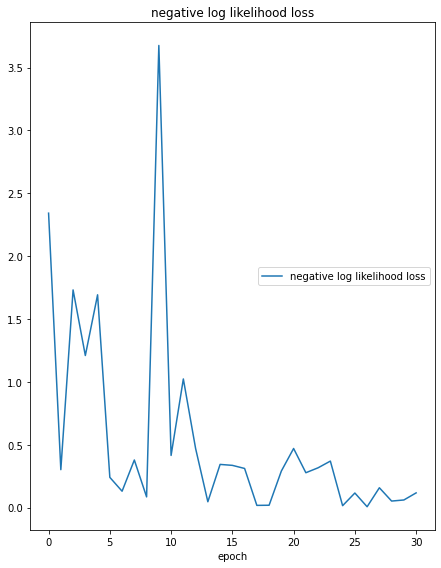

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.007, max:    3.676, cur:    0.117)


In [24]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(1): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        
        tag_scores     = model(encoded_recipe)

        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 500 == 0:
            liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
            liveplot.draw()
            
            
        if i == 15000:
            break

In [25]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

In [26]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Save & Load model

In [27]:
'''
torch.save(model.state_dict(), 'models/recipe.pt')
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load('models/recipe.pt'))
model.eval()


recipe, tags = test_data[4444]

tags_pred = predict_tags(model, recipe)

print('ground truth:')
print(list(zip(recipe, tags)))
print()

print('prediction:')
print(list(zip(recipe, tags_pred)))   


print('ground truth:')
show_markup(recipe, tags)

print('prediction:')
show_markup(recipe, tags_pred)
'''
print()

## Проверка возможностей нейросети на тестовых данных:

### Количество верно предсказанных тэгов:

In [28]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для B-QTY:
  корректно:	 8266
      всего:	 8420
% корректно:	 98.1710213776722

для B-COMMENT:
  корректно:	 5366
      всего:	 7823
% корректно:	 68.59261153010354

для B-RANGE_END:
  корректно:	 113
      всего:	 156
% корректно:	 72.43589743589743

для B-UNIT:
  корректно:	 6787
      всего:	 7074
% корректно:	 95.94288945433985

для B-NAME:
  корректно:	 8728
      всего:	 10278
% корректно:	 84.91924498929752

для I-NAME:
  корректно:	 4336
      всего:	 5528
% корректно:	 78.43704775687411

для I-COMMENT:
  корректно:	 13713
      всего:	 14984
% корректно:	 91.51761879337961

для OTHER:
  корректно:	 1964
      всего:	 4101
% корректно:	 47.89075835162156

----------
в итоге:
  корректно:	 49273
      всего:	 58364
% корректно:	 84.42361729833459


### Матрица Ошибок (Confusion Matrix)

In [29]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags

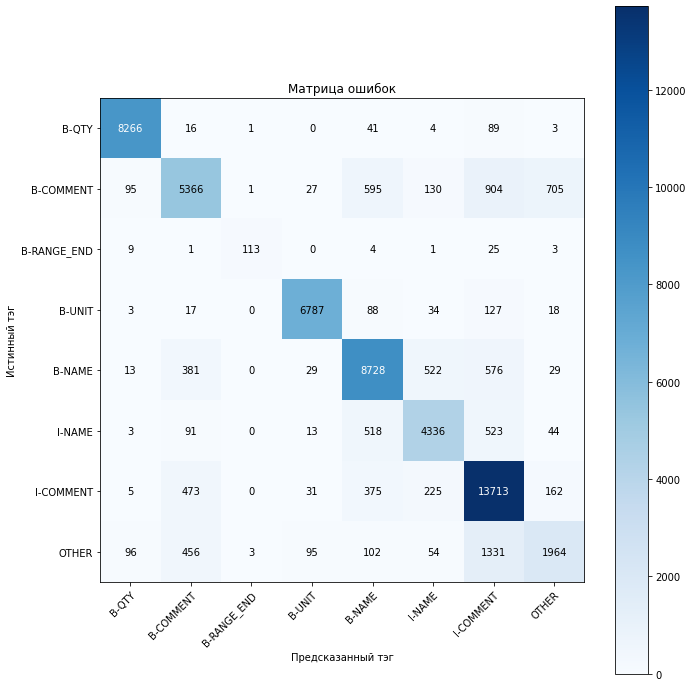

In [30]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

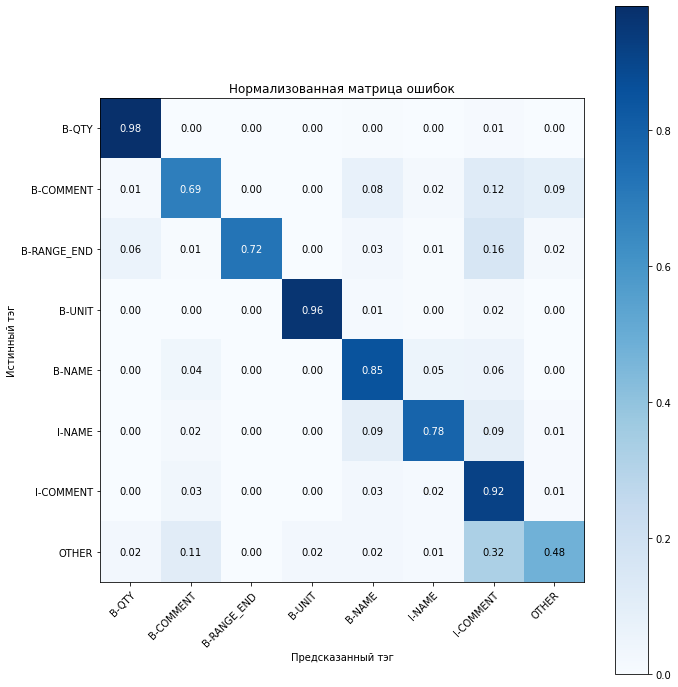

In [31]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()

### Количество верно размеченных рецептов:

In [32]:
correct_recipes, total_recipes = recipe_statistics(model, converter, test_data, 4)

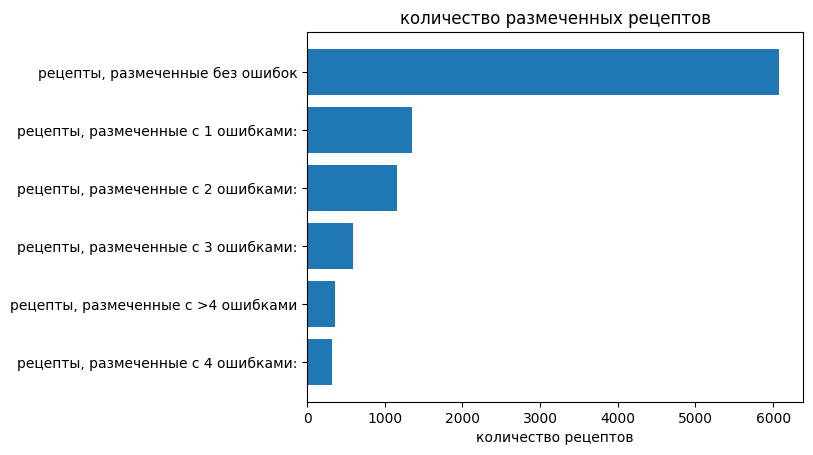

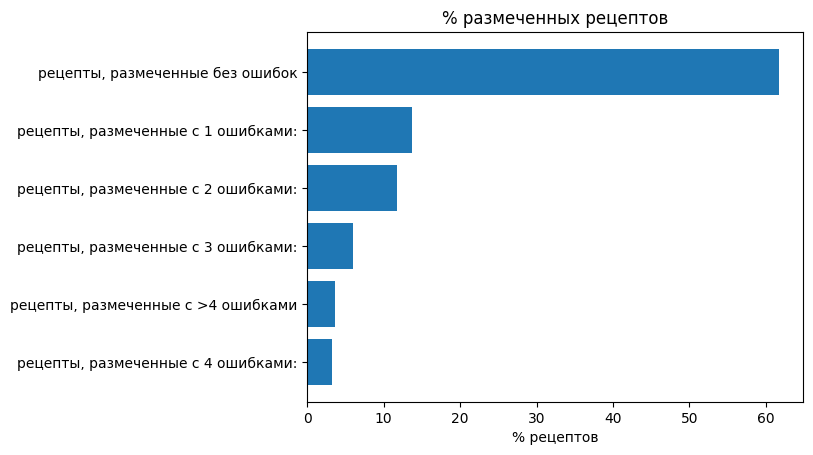

In [33]:
plot_recipe_statistics(correct_recipes)
plot_recipe_statistics(correct_recipes, total_recipes)